# Set environment

In [73]:
import os
import sys
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from example_lorenz import generate_lorenz_data
sys.path.append('../')
from sindy_utils import *
from autoencoder import Autoencoder

### Retrieving data files

In [74]:
data_path           = os.getcwd() + '/'
save_name           = 'lorents_model_analysed'
params              = pickle.load(open('lorenz_trained_model_KAGGLE.pkl', 'rb'))
# params              = pickle.load(open('lorenz_trained_model.pkl', 'rb'))
params['save_name'] = data_path + save_name

### Generating test data

In [75]:
# Generate data
t                   = np.arange(0,20, 0.01)
z0                  = np.array([[-8, 7, 27]])
test_data           = generate_lorenz_data(z0, t, params['input_dim'], linear=False, normalization=np.array([1/40,1/40,1/40])) 
test_data['x']      = test_data['x'].reshape((-1,params['input_dim']))
test_data['dx']     = test_data['dx'].reshape((-1,params['input_dim']))
test_data['z']      = test_data['z'].reshape((-1,params['latent_dim']))
test_data['dz']     = test_data['dz'].reshape((-1,params['latent_dim']))

# Save data
pickle.dump(test_data, open(data_path + 'lorentz_test_data.pkl', 'wb'))

### Plotting Loss evolution of the training loop

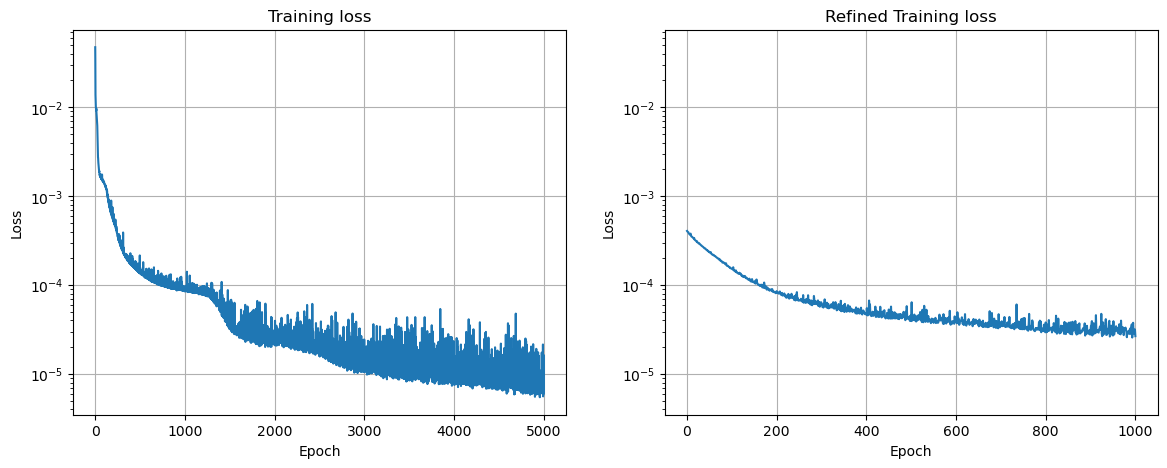

Loss last epoch:			 6.026795e-06
Training Loss epoch 1000: 		 8.72136e-05
Refined training Loss epoch 1000: 	 2.6653779e-05


In [76]:
total_loss                  = params['loss_decoder']
validation_loss             = params['validation_losses']
refined_losses              = params['refined_losses']
refined_validation_losses   = params['refined_validation_losses']
# Plot losses as a function of iteration for nominal and validation
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].semilogy(total_loss)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training loss')
ax[0].grid()
# Set the y-axis limit of ax[1] to be the same as ax[0]
ax[1].set_ylim(ax[0].get_ylim())
ax[1].semilogy(refined_losses)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Refined Training loss')
ax[1].grid()
plt.show()
# Total loss
print('Loss last epoch:\t\t\t', total_loss[-1])
print('Training Loss epoch 1000: \t\t', total_loss[1000])
print('Refined training Loss epoch 1000: \t', refined_losses[1000])

# Simulations

In [77]:
params['sindy_coefficients'] = params['sindy_coefficients'].detach().numpy() 
autoencoder_network = Autoencoder(params)
autoencoder_network.eval()
x_tensor            = torch.tensor(test_data['x'], dtype=torch.float32)
dx_tensor           = torch.tensor(test_data['dx'], dtype=torch.float32)
autoencoder_network.forward([x_tensor, dx_tensor])
z_sim               = autoencoder_network.z.detach().numpy()

lorenz_sim = sindy_simulate(
    test_data['z'][0], t, test_data['sindy_coefficients'], params['poly_order'], params['include_sine']
)


## Plotting and results

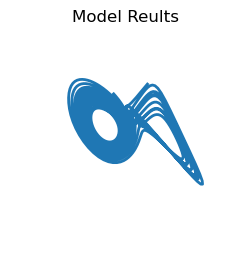

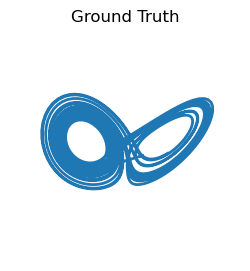

In [78]:
fig1 = plt.figure(figsize=(3,3))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(z_sim[:,0], z_sim[:,1], z_sim[:,2], linewidth=2)
plt.axis('off')
plt.title('Model Reults')
ax1.view_init(azim=120)

fig2 = plt.figure(figsize=(3,3))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot(lorenz_sim[:,0], lorenz_sim[:,1], lorenz_sim[:,2], linewidth=2)
plt.xticks([])
plt.axis('off')
plt.title('Ground Truth')
ax2.view_init(azim=120)

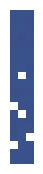

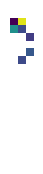

In [79]:
Xi_plot = (params['coefficient_mask']*params['sindy_coefficients'])
Xi_plot[Xi_plot==0] = np.inf
plt.figure(figsize=(1,2))
plt.imshow(Xi_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

Xi_true_plot = np.copy(test_data['sindy_coefficients'])
Xi_true_plot[Xi_true_plot==0] = np.inf
Xi_true_plot[6,1] = -1.
Xi_true_plot[5,2] = 1.
plt.figure(figsize=(1,2))
plt.imshow(Xi_true_plot, interpolation='none')
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.clim([-10,30])

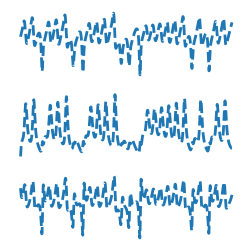

In [80]:
plt.figure(figsize=(3,3))
for i in range(3):
    plt.subplot(3,1,i+1)
    
    plt.plot(t, z_sim[:,i], '--', linewidth=2)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')